In [1]:
import multiSyncPy as msp
from sktime.utils.plotting import plot_correlations
from multiSyncPy import synchrony_metrics as sm
from scipy.signal import hilbert
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from data_functions import get_ant_datafiles_info, preprocess_antcolony_data
from multisync_functions import get_multisync_metrics, get_multisync_statistics
from IPython.display import display

ant_colonies = get_ant_datafiles_info()
ant_colonies

,recording_location,file,location,n_ants,species_name,enterance
0,indoor,dataset/ants/IndoorDataset/Seq0001Object10Imag...,china,10,japanese_arched_ant,0
1,indoor,dataset/ants/IndoorDataset/Seq0002Object10Imag...,china,10,japanese_arched_ant,0
2,indoor,dataset/ants/IndoorDataset/Seq0003Object10Imag...,china,10,japanese_arched_ant,0
3,indoor,dataset/ants/IndoorDataset/Seq0004Object10Imag...,china,10,japanese_arched_ant,0
4,indoor,dataset/ants/IndoorDataset/Seq0005Object10Imag...,china,10,japanese_arched_ant,0
5,outdoor,dataset/ants/OutdoorDataset/Seq0006Object21Ima...,russia,73,carpenter_ant,1
6,outdoor,dataset/ants/OutdoorDataset/Seq0007Object26Ima...,greece,162,little_black_ant,1
7,outdoor,dataset/ants/OutdoorDataset/Seq0008Object31Ima...,russia,133,carpenter_ant,1
8,outdoor,dataset/ants/OutdoorDataset/Seq0009Object50Ima...,russia,193,carpenter_ant,1
9,outdoor,dataset/ants/OutdoorDataset/Seq0010Object30Ima...,usa,101,little_black_ant,0


In [2]:
# take a single "trial" (one group of ants moving through time and space) as an example
example_data = ant_colonies['file'][0]
ants = preprocess_antcolony_data(example_data)

# this one has the ant_id as the index
ant_dict = {ant_id: ants[ants['ant_id'] == ant_id] for ant_id in ants['ant_id'].unique()}

print(f"Number of unique ants: {ants['ant_id'].nunique()}")

Number of unique ants: 10


In [3]:
# a starting approach can be to investigate one single ant only:
# ant_11 = ant_dict[11]
# plot_correlations(ant_11['x'])
# plt.show()

Coherence: 0.14483338190959055
Symbolic entropy: 4.127137193429166
Rho: 0.9801752887280589


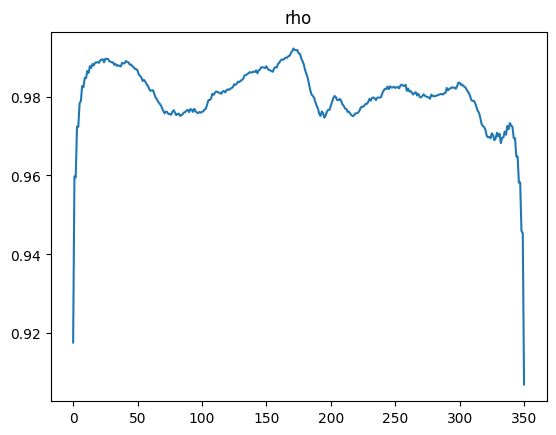

In [4]:
# try "multivariate synchrony" approaches
ant_team_data = np.array([ant_data['x'].values for ant_data in ant_dict.values()])
data_phases = np.angle(hilbert(ant_team_data))

print(f"Coherence: {sm.coherence_team(ant_team_data)}")
print(f"Symbolic entropy: {sm.symbolic_entropy(ant_team_data)}")
print(f"Rho: {sm.rho(data_phases)[1]}")

plt.plot(sm.rho(data_phases)[0])
plt.title('rho')
plt.show()

Ant group investigation, contrasting multisync measurements (coherence, symbolic entropy, rho) between different groups (inside ant groups vs outside ant groups)

In [5]:
# get all metrics for all ant colonies on a certain target variable (ant x or y position) and compare indoor and outdoor ants
preprocessed_colonies = [preprocess_antcolony_data(colony) for colony in ant_colonies['file'].tolist()]
metrics = [get_multisync_metrics(colony, target_var='x', n_observations_per_unit=100, id_column='ant_id') for colony in preprocessed_colonies]
coherence, csd, symbolic_entropy, rho = zip(*metrics)

ant_colonies['coherence'] = coherence
ant_colonies['csd'] = csd
ant_colonies['symbolic_entropy'] = symbolic_entropy
ant_colonies['rho'] = rho

display(ant_colonies.drop(columns=['file']))

,recording_location,location,n_ants,species_name,enterance,coherence,csd,symbolic_entropy,rho
0,indoor,china,10,japanese_arched_ant,0,0.166548,0.179526,3.614594,0.993421
1,indoor,china,10,japanese_arched_ant,0,0.182019,0.191849,4.041930,0.996240
2,indoor,china,10,japanese_arched_ant,0,0.180239,0.185243,4.358343,0.992953
3,indoor,china,10,japanese_arched_ant,0,0.173449,0.231144,4.270625,0.996883
4,indoor,china,10,japanese_arched_ant,0,0.193218,0.225438,4.419719,0.999480
5,outdoor,russia,73,carpenter_ant,1,0.171366,0.224977,3.573615,0.954462
6,outdoor,greece,162,little_black_ant,1,0.173098,0.215991,3.568755,0.953296
7,outdoor,russia,133,carpenter_ant,1,0.171672,0.203844,3.740324,0.994628
8,outdoor,russia,193,carpenter_ant,1,0.198182,0.298324,3.211204,0.918140
9,outdoor,usa,101,little_black_ant,0,0.204757,0.435833,3.126012,0.890657


In [6]:
# compare indoor and outdoor ants
indoor = ant_colonies[ant_colonies['recording_location'] == 'indoor']
outdoor = ant_colonies[ant_colonies['recording_location'] == 'outdoor']

# by adding the coherence measurements for each ant group, we can compare indoor and outdoor ants
results = get_multisync_statistics(indoor, outdoor, round_digits=4)
display(results)

,Metric,T-test (p-value),T-test (statistic),Mann-Whitney U (p-value),Mann-Whitney U (statistic)
0,coherence,0.5958,-0.5523,1.0000,12.0
1,csd,0.1394,-1.6411,0.2222,6.0
2,symbolic_entropy,0.0059,3.7150,0.0159,24.0
3,rho,0.0165,3.0210,0.0317,23.0


In [7]:
c_metrics = []
for i, colony in enumerate(preprocessed_colonies):
    print(f"Colony {i}")
    for n_per_unit in range(10, 100, 10):
        metrics = get_multisync_metrics(colony, target_var='x', n_observations_per_unit=n_per_unit, id_column='ant_id')
        c_metrics.append((i, n_per_unit, ant_colonies['recording_location'][i], *metrics))

    
df = pd.DataFrame(c_metrics, columns=['colony_id', 'n_per_unit', 'recording_location', 'coherence', 'csd', 'symbolic_entropy', 'rho'])

Colony 0
Colony 1
Colony 2
Colony 3
Colony 4
Colony 5
Colony 6
Colony 7
Colony 8
Colony 9


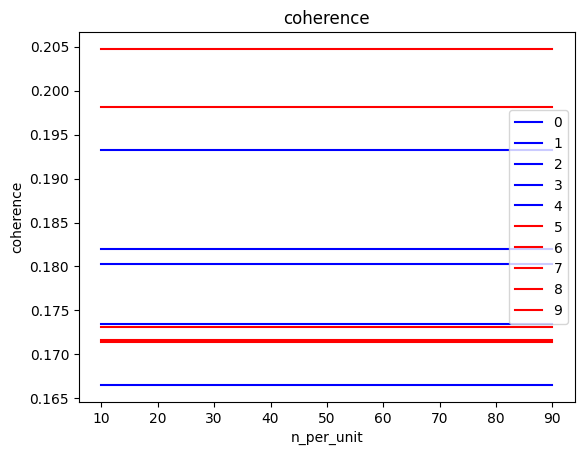

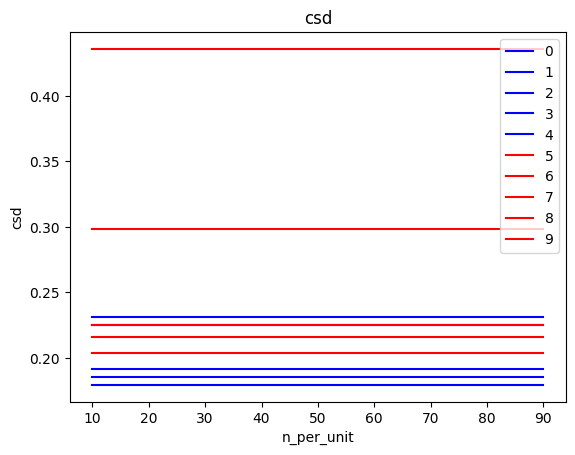

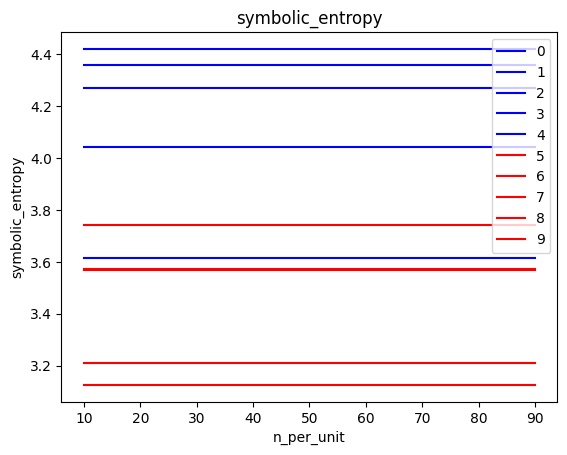

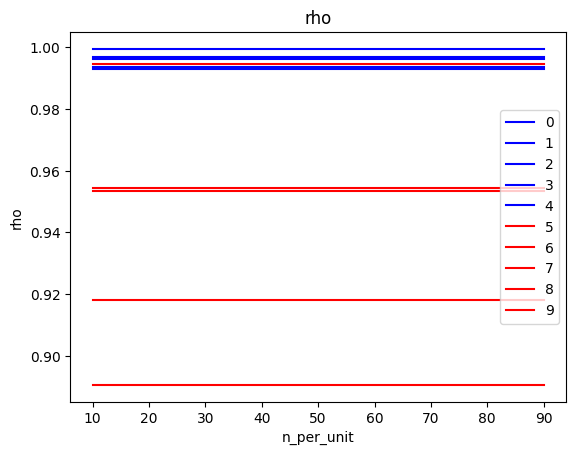

In [8]:
def plot_metrics(df, metric_name):
    for name, group in df.groupby('colony_id'):
        plt.plot(group['n_per_unit'], group[metric_name], label=name, color='blue' if group['recording_location'].iloc[0] == 'indoor' else 'red')
    plt.title(metric_name)
    plt.xlabel('n_per_unit')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

plot_metrics(df, 'coherence')
plot_metrics(df, 'csd')
plot_metrics(df, 'symbolic_entropy')
plot_metrics(df, 'rho')

Bird flocking investigation, contrasting multisync measurements (coherence, symbolic entropy, rho) between different groups (not grouped birds vs grouped birds)

In [9]:
from data_functions import process_bird_data
from os.path import isfile
import zipfile

if not isfile('dataset/birds/birds_grouped.csv'):
    with zipfile.ZipFile('dataset/birds/birds_grouped.zip', 'r') as zip_ref:
        zip_ref.extractall('dataset/birds')

birds = pd.read_csv('dataset/birds/birds_grouped.csv')
birds_processed_0 = process_bird_data(birds, selected_class=0, target_col_pre='x')
birds_processed_1 = process_bird_data(birds, selected_class=1, target_col_pre='x')

total = min(len(birds_processed_0), len(birds_processed_1))
birds_processed = birds_processed_0[:total] + birds_processed_1[:total]
    
birds_processed = pd.DataFrame(birds_processed, columns=['scene', 'class', 'coherence', 'csd', 'symbolic_entropy', 'rho'])
display(birds_processed)

ungrouped = birds_processed[birds_processed['class'] == 0]
grouped = birds_processed[birds_processed['class'] == 1]

results = get_multisync_statistics(ungrouped, grouped)
display(results)

,scene,class,coherence,csd,symbolic_entropy,rho
0,0,0,0.229295,0.236731,4.131303,0.380134
1,1,0,0.235060,0.251640,3.720556,0.347738
2,2,0,0.212904,0.224304,3.813729,0.431417
3,3,0,0.214972,0.236619,3.786472,0.335803
4,4,0,0.206250,0.212189,3.770596,0.322998
5,5,0,0.233786,0.264526,3.769904,0.400524
6,6,0,0.215686,0.240577,3.844451,0.332944
7,7,0,0.209810,0.221392,3.860840,0.306387
8,8,0,0.205782,0.211628,3.955175,0.310576
9,9,0,0.238251,0.263853,3.859877,0.383707


,Metric,T-test (p-value),T-test (statistic),Mann-Whitney U (p-value),Mann-Whitney U (statistic)
0,coherence,0.000000,-19.139468,0.000183,0.0
1,csd,0.000000,-18.483988,0.000183,0.0
2,symbolic_entropy,0.222306,1.264137,0.677585,56.0
3,rho,0.000212,-4.621833,0.001706,8.0
